### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

RANDOM_STATE = 1234

### Изучение данных из файла

In [2]:
path = ''
#path = '/datasets/'
data = pd.read_csv(path + 'taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)
df = data.resample('1H').sum()

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Согласно документации к данным**

Целевой признак:
- 'num_orders' – количество заказов 

**Пропуски**

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

**Вывод**

- Данные представлены за 6 месяцев с марта по август 2018 г.
- Пропуски в данных отсутвуют. Количество объектов в датасете достаточно.
- Целевой признак имеет целочисленный тип. 

### Предобработка данных

In [7]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


- Тренд и сезонность

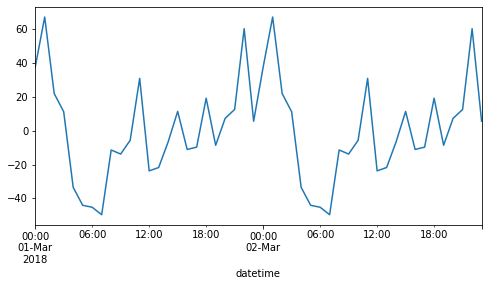

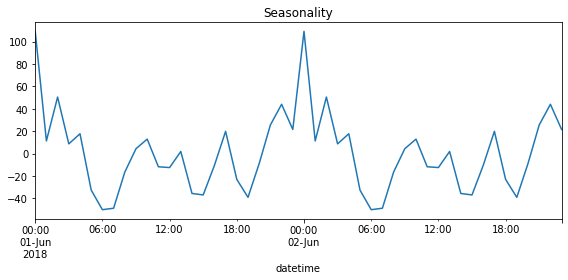

In [8]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-02'])
plt.figure(figsize=(8, 4))
decomposed.seasonal.plot(ax=plt.gca())
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-02'])
plt.figure(figsize=(8, 4))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()
plt.title('Seasonality')
plt.tight_layout()

In [9]:
decomposed = seasonal_decompose(data.resample('1D').sum())

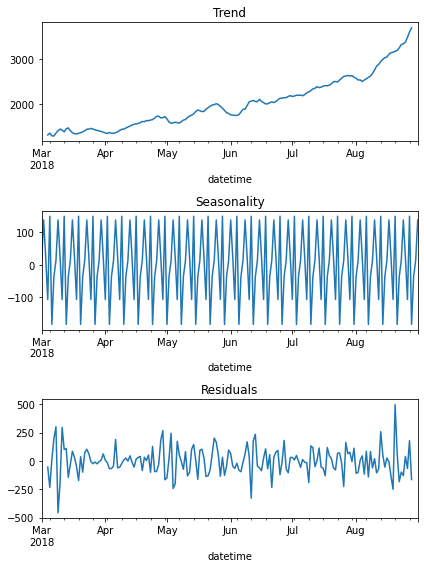

In [10]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Есть тренд и сезонность. Исследуем ряд на стационарность. 

- Стационарность временного ряда:

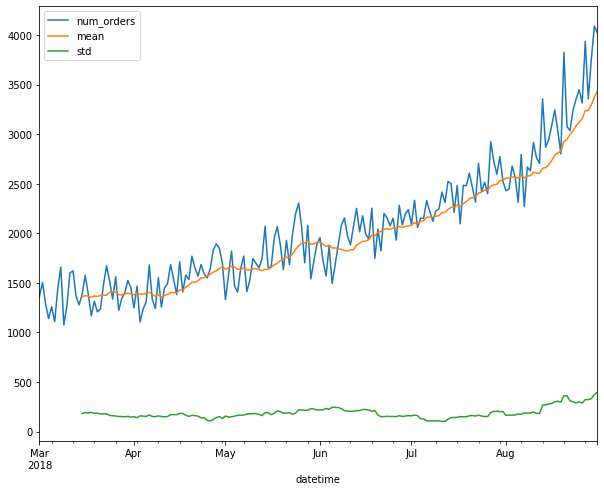

In [11]:
data = data.resample('1D').sum()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot(figsize=(10, 8));

Среднее и стандартное отклонение временного ряда меняются, следовательно исходный ряд нестационарен. 

Добавим столбец разностей временного ряда:

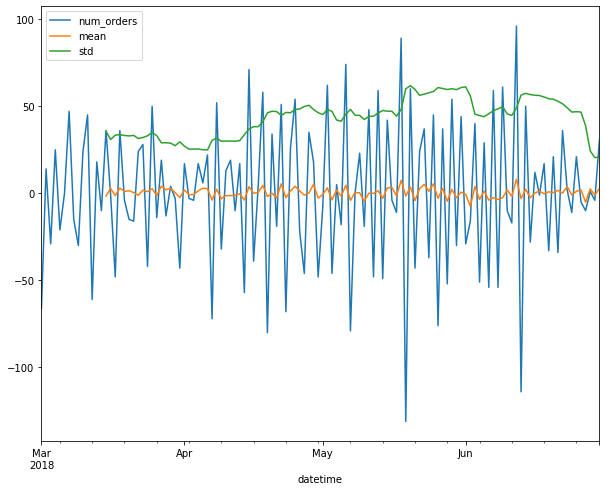

In [12]:
data = df - df.shift()
data = data['2018-01':'2018-06'].resample('1D').sum()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot(figsize=(10, 8));

Тренд отсутвует, разности временного ряда более стационарны.

- Создадим новые признаки:

In [13]:
def make_features(data, name_target, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[name_target].shift(lag)

    data['rolling_mean'] = data[name_target].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(df, 'num_orders', 4, 24)

df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN


   
- **Работа с аномальными значениями**

In [15]:
anomalies = df.query('num_orders > 180')[['num_orders', 'dayofweek', 'hour']]

In [16]:
print(anomalies.dayofweek.unique())
anomalies.hour.unique()

[5 1 3 4 0 6 2]


array([ 1,  0, 22, 23,  2,  3, 17,  4, 10, 16, 21, 15,  9, 14, 20,  8, 18])

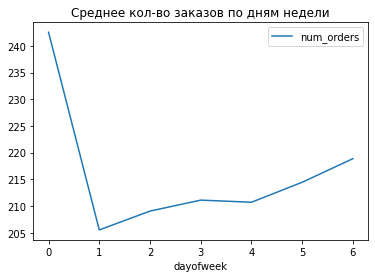

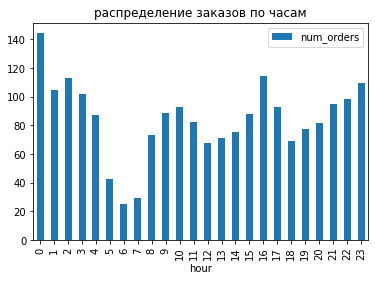

In [17]:
anomalies.pivot_table(index='dayofweek', values='num_orders', aggfunc='mean').plot().set(title='Среднее кол-во заказов по дням недели')
df.pivot_table(index='hour', values='num_orders', aggfunc='mean').plot(kind='bar').set(title='распределение заказов по часам')
plt.show()

На графике зависимости количесвта заказов от дня недели видно, что наибольшее количество заказов в пн.

На гистограмме распределения заказов по часам:
- Пики в 24 часа и в 16 часов;
- Минимальное количество заказов 6-7 часов.

Рассмотрим количесвто заказов по понедельникам: 

<AxesSubplot:xlabel='datetime'>

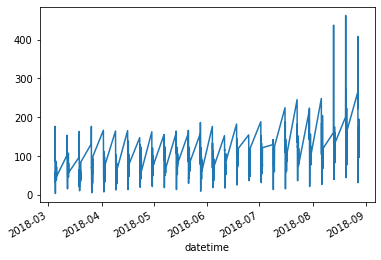

In [18]:
df.query('dayofweek == 0')['num_orders'].plot()

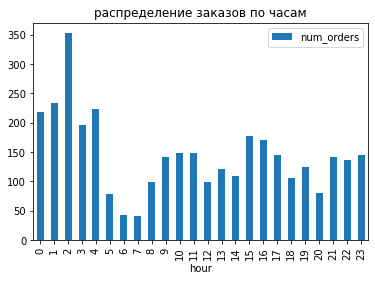

In [19]:
temp = df['2018-08':].query('dayofweek == 0')
temp.pivot_table(index='hour', values='num_orders', aggfunc='mean').plot(kind='bar').set(title='распределение заказов по часам')
plt.show()

Пики по понедельникам приходятся на август. В этот период максимальное количество заказов в 2 часа, минимальное 6-7 часов. Рассмотрим данные за август:

In [20]:
df['2018-08':].query('dayofweek == 0 and hour.isin([1, 2, 3])')

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-08-06 01:00:00,170,0,1,248.0,144.0,97.0,101.0,101.500000
2018-08-06 02:00:00,104,0,2,170.0,248.0,144.0,97.0,103.833333
2018-08-06 03:00:00,184,0,3,104.0,170.0,248.0,144.0,102.041667
2018-08-13 01:00:00,273,0,1,160.0,185.0,118.0,135.0,112.166667
2018-08-13 02:00:00,437,0,2,273.0,160.0,185.0,118.0,116.166667
2018-08-13 03:00:00,168,0,3,437.0,273.0,160.0,185.0,127.833333
2018-08-20 01:00:00,272,0,1,200.0,167.0,121.0,93.0,117.583333
2018-08-20 02:00:00,462,0,2,272.0,200.0,167.0,121.0,125.041667
2018-08-20 03:00:00,224,0,3,462.0,272.0,200.0,167.0,138.708333


Похоже нашли понедельники с максимальными значениями заказов, и можно было бы усреднить значения в 1, 2, 3 часа и заполнить значение `num_orders` в 2 часа в августе в пн этим средним.

In [21]:
df['day'] = df.index.day
mean_orders_02 = df['2018-08':].query('dayofweek == 0 and hour.isin([1, 2, 3])').pivot_table(index='day', values='num_orders')
mean_orders_02 = mean_orders_02.astype('int')

In [22]:
df.loc['2018-08'].loc[(df['dayofweek'] == 0) & (df['hour'] == 2), 'num_orders'] = mean_orders_02.values

In [23]:
df['2018-08':].query('dayofweek == 0 and hour.isin([1, 2, 3])') 

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean,day
datetime,,,,,,,,,
2018-08-06 01:00:00,170,0,1,248.0,144.0,97.0,101.0,101.500000,6
2018-08-06 02:00:00,152,0,2,170.0,248.0,144.0,97.0,103.833333,6
2018-08-06 03:00:00,184,0,3,104.0,170.0,248.0,144.0,102.041667,6
2018-08-13 01:00:00,273,0,1,160.0,185.0,118.0,135.0,112.166667,13
2018-08-13 02:00:00,292,0,2,273.0,160.0,185.0,118.0,116.166667,13
2018-08-13 03:00:00,168,0,3,437.0,273.0,160.0,185.0,127.833333,13
2018-08-20 01:00:00,272,0,1,200.0,167.0,121.0,93.0,117.583333,20
2018-08-20 02:00:00,319,0,2,272.0,200.0,167.0,121.0,125.041667,20
2018-08-20 03:00:00,224,0,3,462.0,272.0,200.0,167.0,138.708333,20


Посмотрим как распределяются заказы по месяцам:

In [24]:
# num_orders_month = df.groupby('month')['num_orders'].sum()
# sns.barplot(x=num_orders_month.index, y=num_orders_month.values, palette="Set2").set(title='Распределение заказов по месяцам', ylabel='num_orders');

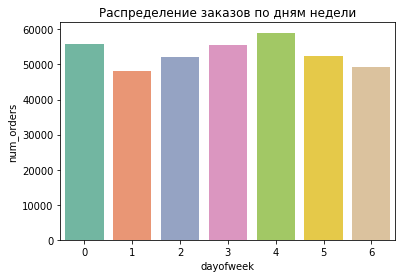

In [25]:
sns.barplot(data = df.groupby('dayofweek')['num_orders'].sum().reset_index(), x ="dayofweek", y = "num_orders", palette="Set2").set(
    title='Распределение заказов по дням недели');

**Вывод**

- в данных были обнаружены и устранены выбросы.

Из построенных графиков видно, что

- большинство заказов было сделано в августе;
- на гистограмме распределения заказов по дням недели больше всего заказов в пн и пт;

### Обучение моделей

Разделим датасет на тренировочную и тестовую выборки:
- тренировочная выборка - 90%
- тестовая выборка – 10%

In [26]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Размер полученных выборок:

In [27]:
print("train size:", train_features.shape)
print("test size:", test_features.shape)

train size: (3950, 8)
test size: (442, 8)


- Кросс-валидация

In [28]:
def get_cv_scores(model, features, target):
    scores = cross_val_score(
                            model,
                            features, target,
                            cv=TimeSeriesSplit(n_splits=5).split(features),
                            scoring="neg_root_mean_squared_error"
    )
    return print("best_scores", np.mean(scores)*(-1))
    

- GridSearchCV

In [29]:
grid_dt = {'max_depth': range(3, 15, 3)}
grid_rdf = {'n_estimators': range(5, 50, 10), 'max_depth': range(3, 15, 5)}

In [30]:
my_cv = TimeSeriesSplit(n_splits=5).split(train_features)

**Линейная регрессия**

In [31]:
model = LinearRegression().fit(train_features, train_target)
get_cv_scores(model, train_features, train_target)

best_scores 31.46211838381605


**Решающее дерево**

In [32]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
grs = GridSearchCV(model, grid_dt, cv=my_cv, scoring="neg_root_mean_squared_error")
grs.fit(train_features, train_target)
print(grs.best_params_)
print(grs.best_score_*(-1))

{'max_depth': 6}
29.099792184941492


**Случайный лес**

In [33]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
grs = GridSearchCV(model, grid_rdf, cv=TimeSeriesSplit(n_splits=5).split(train_features), scoring="neg_root_mean_squared_error")
grs.fit(train_features, train_target)
print(grs.best_params_)
print(grs.best_score_*(-1))

{'max_depth': 13, 'n_estimators': 35}
25.320850285859674


**XGBoost**

In [34]:
model = xgb.XGBRegressor()
param_search = {'max_depth': range(3, 15, 2), 'n_estimators': [30, 50]}

my_cv = TimeSeriesSplit(n_splits=5).split(train_features)
gsearch = GridSearchCV(estimator=model, cv=my_cv,
                        param_grid=param_search, scoring="neg_root_mean_squared_error")
gsearch.fit(train_features, train_target)
print(gsearch.best_params_)
print(gsearch.best_score_*(-1))

{'max_depth': 3, 'n_estimators': 50}
25.607478563969188


**Вывод**

Последний лучший результат у модели случайного леса, *RMSE = 25.32* 

### Обучение модели на тестовой выборке

In [35]:
model = RandomForestRegressor(n_estimators=35, max_depth=13, random_state=RANDOM_STATE)
# model = LinearRegression()
model.fit(train_features, train_target)
predictions = model.predict(test_features)
print("RMSE модели линейной регрессии на тестовой выборке:", mean_squared_error(test_target, predictions) ** 0.5)

RMSE модели линейной регрессии на тестовой выборке: 44.70332550582892


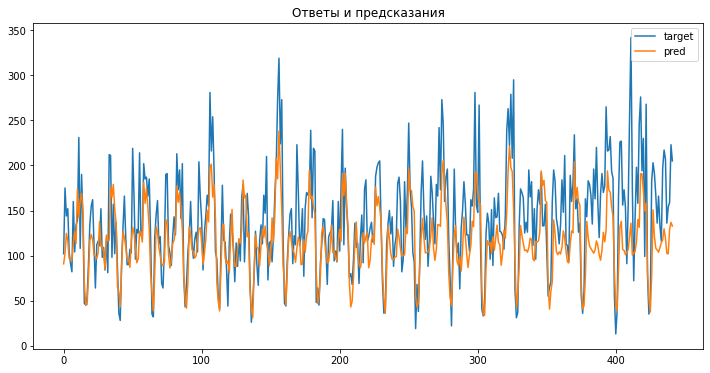

In [36]:
test_target.reset_index().drop('datetime', axis=1).plot(figsize=(12,6)).set(title='Ответы и предсказания')
plt.plot(predictions);
plt. legend(['target', 'pred']);
plt.show()

### Проверка модели на адекватность

In [37]:
pred_previous = test_target.shift()
pred_previous.iloc[0] = train_target.iloc[-1]
print('RMSE:', mean_squared_error(pred_previous, test_target)**0.5)

RMSE: 55.94336987958594


**Вывод**

Было проведено исследование временного ряда, задачей которого было прогнозирование заказов такси. Наилучший результат показала модель линейной регрессии на тестовой выборке, *RMSE = 44.7*.